<a href="https://colab.research.google.com/github/karsarobert/Deep-Learning-2022/blob/main/09/PTE_DL9_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
keras = tf.keras

In [ ]:
temp = pd.read_csv(
    "temp.csv",
    names=["Oszlop1"]).values

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Idő")
    plt.ylabel("Hőmérséklet")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    


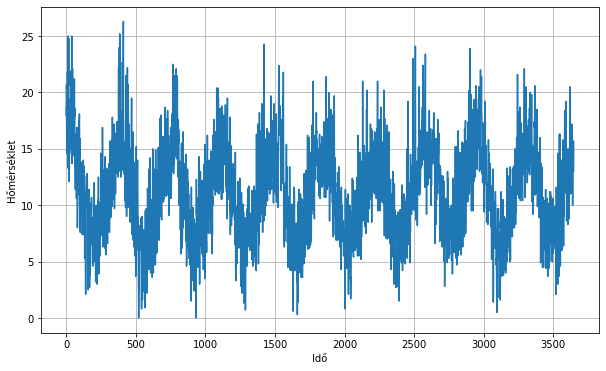

In [ ]:
time = np.arange(3647)
series = temp.reshape(3647,)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Előrejelzés gépi tanulással

Először is, egy modellt fogunk képezni a következő lépés előrejelzésére az előző 30 lépés alapján, ezért létre kell hoznunk egy 30 lépésből álló ablakokból álló adathalmazt a képzéshez.


In [ ]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series) # belovassa az adatokat tf.data.Dataset formátumban
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # az adatokat '5'-ös ablakokba rendezi és a +1 jelenti az y-t
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # a dataset tensorok formájában tartalmazza az adatokat 5-ösével
    dataset = dataset.shuffle(shuffle_buffer) # összekeverjük az adatokat
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # a tensorokat szétvágjuk x, y-ra ahol y a kimenet
    dataset = dataset.batch(batch_size).prefetch(1) # beállítjuk a batch méretet 2-re és előkészítjük a következő adatokat is
    return dataset

In [ ]:
split_time = 1000 # előállítjuk a train és valid adatokat numpy array szeleteléssel
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

A statisztikákban a Huber veszteség a robusztus regresszióban használt veszteségfüggvény, amely kevésbé érzékeny az adatokban szereplő kiugró értékekre, mint a négyzeteshiba
Kis értékek esetén L2, nagyobb értékek esetén L1-ként viselkedik

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size]) # nincs aktivációs fgv így csak egy lineáris fgv ként viselkedik
])
# beállítunk egy LR ütemezőt nagyon kis értéktől indulunk és folyamatosan növeljük a LR-t
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
31/31 [==============================] - 1s 5ms/step - loss: 18.1179 - mae: 18.6175 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 17.0665 - mae: 17.5651 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 15.8484 - mae: 16.3465 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 14.5422 - mae: 15.0410 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 13.1428 - mae: 13.6414 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 11.6501 - mae: 12.1480 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 10.0795 - mae: 10.5736 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 8.4820 - mae: 8.9720 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 6.9386 - mae: 7.4263 - lr

(1e-06, 0.001, 0.0, 20.0)

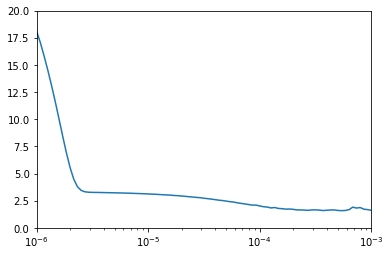

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

# Meg keressük a legnagyobb LR-t amit még használhatunk!

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size) # előállítjuk a dataseteket a korábbi fgv segítségével 
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9) # lehet próbálkozni mással is pl adam
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10) # korai megállás ha 10 korszakon keresztül nem javulnak a lossok
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/500
31/31 [==============================] - 1s 28ms/step - loss: 9.5528 - mae: 10.0427 - val_loss: 3.9016 - val_mae: 4.3773
Epoch 2/500
31/31 [==============================] - 1s 24ms/step - loss: 3.6899 - mae: 4.1638 - val_loss: 3.2022 - val_mae: 3.6735
Epoch 3/500
31/31 [==============================] - 1s 18ms/step - loss: 3.3898 - mae: 3.8662 - val_loss: 3.0181 - val_mae: 3.4902
Epoch 4/500
31/31 [==============================] - 1s 24ms/step - loss: 3.2337 - mae: 3.7045 - val_loss: 2.8917 - val_mae: 3.3619
Epoch 5/500
31/31 [==============================] - 1s 24ms/step - loss: 3.0681 - mae: 3.5373 - val_loss: 2.7647 - val_mae: 3.2341
Epoch 6/500
31/31 [==============================] - 1s 23ms/step - loss: 2.9548 - mae: 3.4212 - val_loss: 2.6606 - val_mae: 3.1302
Epoch 7/500
31/31 [==============================] - 1s 24ms/step - loss: 2.8988 - mae: 3.3661 - val_loss: 2.5672 - val_mae: 3.0352
Epoch 8/500
31/31 [==============================] - 1s 24ms/step - loss: 2

In [ ]:
for element in train_set.take(1):
  print(element)
# egy dataset tartalma 30 elem ennyi volt az ablak méret, és 32 db ilyen 30-as tensor a batch méret miatt

(<tf.Tensor: shape=(32, 30), dtype=float64, numpy=
array([[15.5, 15.6, 13.1, 15.2, 14.1, 12.5, 14.6, 10.4, 13.9, 11.9, 13.5,
         9.8, 14. , 21.5, 19.5, 16.7, 19.1, 11. ,  9. , 10. , 14.6, 12.5,
        17.2, 19.2, 22.2, 15.7, 14.2,  9.8, 14. , 17.5],
       [13.4, 10.5, 14.2, 11.5, 13. , 15. , 14.7, 12.6, 12.5, 13.5, 14.8,
        17.2,  9.7, 12.1, 12.8, 11.2, 16.4, 15.6, 13.3, 11. , 11.1, 15. ,
        12.8, 15. , 14.2, 14. , 15.5, 13.3, 15.6, 15.2],
       [ 4. ,  5.3,  6.3,  8.5, 11.5,  7.7,  9.2,  7.8,  6.3,  6.3,  8.6,
         6.1, 13.2,  9.9,  4.7,  5.8, 14.9, 10.7,  8.6,  9.4,  5.7, 10.9,
        13.1, 10.4,  8.2,  9.8,  7.5,  5.8,  9.8,  7.9],
       [ 9.4, 13.2,  6.6,  5.1, 12.1, 11.2,  8.5,  4.6,  7. , 14.2, 12.7,
         7.6,  4. , 10. , 10.5,  5. ,  4.5,  8.2,  4.3,  9.8,  5.8,  5. ,
         8.5,  9. ,  3.6,  6.7,  6.7, 10.1, 15. ,  8.9],
       [15.9, 13. , 14.1, 15.8, 24. , 18. , 19.7, 25.2, 20.5, 19.3, 15.8,
        17. , 18.4, 13.3, 14.6, 12.5, 17. , 17.1, 14. ,

In [ ]:
def model_forecast(model, series, window_size):  # ua mint feljebb a window_dataset fgv annyi eltéréssel, hogy itt nem kell y-t generálni
    ds = tf.data.Dataset.from_tensor_slices(series) 
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0] # előrejelzés készítése 

In [ ]:
lin_forecast.shape

(2647,)

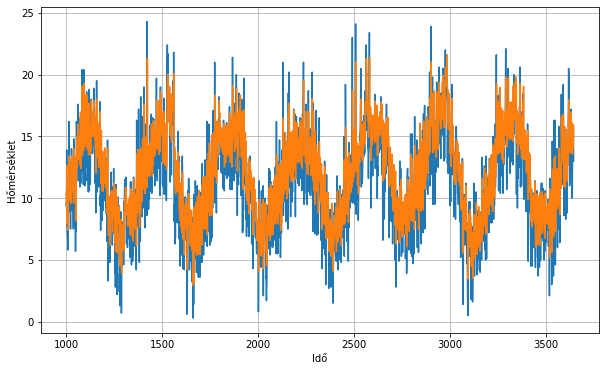

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

2.0421932

### Dense Model Forecasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])
# LR kereséshez a beállítások ua mint feljebb
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 10.6752 - mae: 11.1744 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 10.5432 - mae: 11.0424 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 10.3830 - mae: 10.8820 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 10.2019 - mae: 10.7006 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 9.9966 - mae: 10.4950 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 9.7647 - mae: 10.2626 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 9.5036 - mae: 10.0008 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 9.2070 - mae: 9.7039 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 8.8732 - mae: 9.3699 - lr: 2

(1e-07, 0.005, 0.0, 30.0)

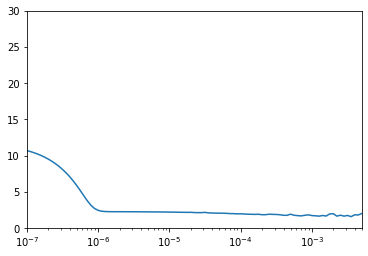

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/500
31/31 [==============================] - 2s 30ms/step - loss: 4.0562 - mae: 4.5286 - val_loss: 2.4643 - val_mae: 2.9293
Epoch 2/500
31/31 [==============================] - 1s 25ms/step - loss: 2.2903 - mae: 2.7545 - val_loss: 2.0267 - val_mae: 2.4812
Epoch 3/500
31/31 [==============================] - 1s 20ms/step - loss: 2.1340 - mae: 2.5928 - val_loss: 1.9292 - val_mae: 2.3835
Epoch 4/500
31/31 [==============================] - 1s 25ms/step - loss: 2.0684 - mae: 2.5291 - val_loss: 1.9152 - val_mae: 2.3713
Epoch 5/500
31/31 [==============================] - 1s 19ms/step - loss: 2.0459 - mae: 2.5086 - val_loss: 1.8746 - val_mae: 2.3240
Epoch 6/500
31/31 [==============================] - 1s 25ms/step - loss: 1.9927 - mae: 2.4508 - val_loss: 1.9074 - val_mae: 2.3615
Epoch 7/500
31/31 [==============================] - 1s 20ms/step - loss: 1.9700 - mae: 2.4265 - val_loss: 1.8456 - val_mae: 2.2964
Epoch 8/500
31/31 [==============================] - 1s 24ms/step - loss: 1.

In [ ]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

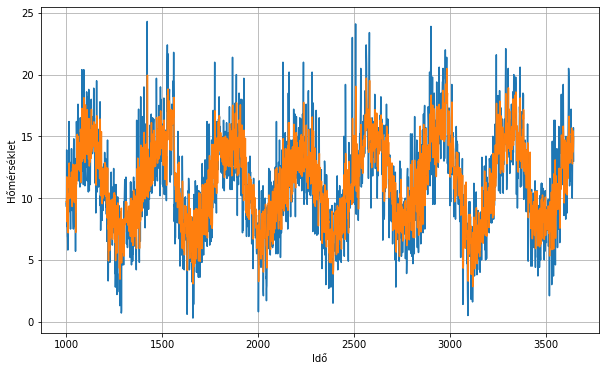

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

1.9332281